In [1]:
from copy import deepcopy
from graphviz import Digraph
import heapq
import random
from collections import deque
import time
import statistics

In [2]:
class Node:
#Trạng thái ban đầu
  def __init__(self, state, action=None, parent=None,cost=0, heuristic=0):
    self.state = state
    self.id = str(self)
    self.action = action
    self.parent = parent
    self.cost=cost
    self.ID= self.get_node_str()
    self.heuristic = heuristic

#Trạng thái đích
  def is_goal(self):
      goals = [
          [[1,2,3],[4,5,6],[7,8,0]],
          [[8,7,6],[5,4,3],[2,1,0]],
          [[0,1,2],[3,4,5],[6,7,8]],
          [[0,8,7],[6,5,4],[3,2,1]]
      ]
      return self.state in goals

  def __str__(self):
    return "\n".join(" ".join("_" if x == 0 else str(x) for x in row) for row in self.state)

#Tìm vị trí ô 0
  def get_blank_pos(self, state):
      for i in range(3):
        for j in range(3):
          if state[i][j] == 0:
            return i, j

  def get_dest_pos(self, action, pi, pj):
      if action == 'L':
        pj += 1
      if action == 'R':
        pj -= 1
      if action == 'U':
        pi += 1
      if action == 'D':
        pi -= 1
      return pi, pj

  def get_successors(self):
    successors = []
    actions = ['L', 'R', 'U', 'D']
    for action in actions:
      new_state = deepcopy(self.state)
      moved_state = self.get_successor(action, new_state)
      if moved_state is not None:
        successors.append(Node(moved_state, action, self, self.cost + 1))
    #Thêm vào các node đã swap
    if(self.parent is not None):
          successors.extend(self.swap())
    return successors


  def get_successor(self, action, state):
    pi, pj = self.get_blank_pos(state)
    pi, pj = self.get_dest_pos(action, pi, pj)
    if 0 <= pi and pi < 3 and 0 <= pj and pj < 3:
      if action == 'L':
        state[pi][pj - 1] = state[pi][pj]
      if action == 'R':
        state[pi][pj + 1] = state[pi][pj]
      if action == 'U':
        state[pi-1][pj] = state[pi][pj]
      if action == 'D':
        state[pi+1][pj] = state[pi][pj]
      state[pi][pj] = 0
      return state
    return None

  def get_id(self):
    return self.id

  def get_node_str(self):
    return str(self)

  def get_action(self):
    return self.action

  def swap(self):
    successors = []
    # Swap top-left <-> bottom-right
    if self.state[0][0] != 0 and self.state[2][2] != 0:
        new_state = deepcopy(self.state)
        new_state[0][0], new_state[2][2] = new_state[2][2], new_state[0][0]
        successors.append(Node(new_state, "Corner swap", self, self.cost + 1))
    # Swap top-right <-> bottom-left
    if self.state[0][2] != 0 and self.state[2][0] != 0:
        new_state = deepcopy(self.state)
        new_state[0][2], new_state[2][0] = new_state[2][0], new_state[0][2]
        successors.append(Node(new_state, "Corner swap", self, self.cost + 1))

    #Kiểm tra các cặp cạnh kề nhau
    for i in range(3):
      for j in range(3):
        u=self.state[i][j]
        if(u==0):
          continue
        for (ni, nj) in [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]:
          if 0 <= ni and ni < 3 and 0 <= nj and nj < 3:
            v=self.state[ni][nj]
            if v != 0 and v + u == 9:
              s = deepcopy(self.state)
              s[i][j], s[ni][nj] = s[ni][nj], s[i][j]
              successors.append(Node(s, f"Swap {u}_{v}", self, self.cost + 1))
    return successors

  def __lt__(self,other):
    return self.cost < other.cost


  def draw(self, dot):
    dot.node(self.get_id(), self.get_node_str())
    if self.parent is not None:
      dot.edge(self.parent.get_id(), self.get_id(), self.get_action())

#Hàm state ngẫu nhiên
  @staticmethod
  def create_random_start():
    numbers = list(range(9))
    random.shuffle(numbers)
    state = [numbers[i*3:(i+1)*3] for i in range(3)]
    return Node(state)

In [3]:
class Heuristic:
    def __call__(self, state):
        raise NotImplementedError("Must override method __call__()")

class ManhattanHeuristic(Heuristic):
    goals = [
        [[1,2,3],[4,5,6],[7,8,0]],
        [[8,7,6],[5,4,3],[2,1,0]],
        [[0,1,2],[3,4,5],[6,7,8]],
        [[0,8,7],[6,5,4],[3,2,1]]
    ]

    def __call__(self, state):
        min_distance = None
        for goal in self.goals:
            distance = 0
            for i in range(3):
                for j in range(3):
                    val = state[i][j]
                    if val != 0:
                        for gi in range(3):
                            for gj in range(3):
                                if goal[gi][gj] == val:
                                    distance += abs(i - gi) + abs(j - gj)
            if min_distance is None or distance < min_distance:
                min_distance = distance
        return (min_distance + 1) // 2

class MisplacedHeuristic(Heuristic):
    goals = [
        [[1,2,3],[4,5,6],[7,8,0]],
        [[8,7,6],[5,4,3],[2,1,0]],
        [[0,1,2],[3,4,5],[6,7,8]],
        [[0,8,7],[6,5,4],[3,2,1]]
    ]

    def count_misplaced(self, state, goal):
        count = 0
        for i in range(3):
            for j in range(3):
                if state[i][j] != goal[i][j] and state[i][j] != 0:
                    count += 1
        return count

    def __call__(self, state):
        min_misplaced = None
        for goal in self.goals:
            misplaced = self.count_misplaced(state, goal)
            if min_misplaced is None or misplaced <= min_misplaced:
                min_misplaced = misplaced
        return (min_misplaced + 1) // 2



In [4]:
class A_star:
    def __init__(self, start_node, heuristic: Heuristic):
        self.start_node = start_node
        self.heuristic = heuristic
        self.start_node.heuristic = self.heuristic(self.start_node.state)

    def reconstruct_path(self, node):
        path = []
        while node:
            path.append(node)
            node = node.parent
        path.reverse()
        return path

    def solve(self):
        frontier = []
        explored = set()
        node_explored = 0

        if self.start_node.is_goal():
            return self.reconstruct_path(self.start_node), self.start_node.cost, node_explored

        heapq.heappush(frontier, (self.start_node.cost + self.start_node.heuristic, self.start_node))
        best_cost = {self.start_node.get_node_str(): self.start_node.cost}

        while frontier:
            f_val, current = heapq.heappop(frontier)
            node_explored += 1
            if current.is_goal():
                return self.reconstruct_path(current), current.cost, node_explored

            if current.get_node_str() in explored:
                continue

            explored.add(current.get_node_str())
            for child in current.get_successors():
                child.heuristic = self.heuristic(child.state)
                total_cost = child.cost + child.heuristic
                state_str = child.get_node_str()
                if state_str not in best_cost or child.cost < best_cost[state_str]:
                    best_cost[state_str] = child.cost
                    heapq.heappush(frontier, (total_cost, child))

        return None, None, node_explored

In [5]:
class BFS:
    def __init__(self, start_node, max_limit=50000):
        self.start_node = start_node
        self.max_limit = max_limit

    def solve(self):

        if self.start_node.is_goal():
            return [self.start_node], 0, 0

        frontier = deque([self.start_node])
        explored = set()
        nodes_expanded = 0

        while frontier:
            current = frontier.popleft()
            nodes_expanded += 1

            if current.is_goal():
                path = []
                while current:
                    path.append(current)
                    current = current.parent
                path.reverse()
                return path, path[-1].cost, nodes_expanded

            explored.add(current.get_node_str())
            for child in current.get_successors():
                if child.get_node_str() not in explored:
                    frontier.append(child)

        return None, None, nodes_expanded


In [6]:
def illustrate_search_tree(start_node, n, heuristic_obj):
  astar = A_star(start_node, heuristic_obj)
  dot = Digraph()
  frontier = []
  heapq.heappush(frontier, (start_node.cost + start_node.heuristic, start_node))
  explored = set()
  count = 0

  while frontier and count < n:
      f_value, current = heapq.heappop(frontier)
      if current.get_node_str() in explored:
          continue

      explored.add(current.get_node_str())
      current.draw(dot)
      count += 1

      for child in current.get_successors():
          child.heuristic = astar.heuristic(child.state)
          total_cost = child.cost + child.heuristic
          heapq.heappush(frontier, (total_cost, child))

  return dot



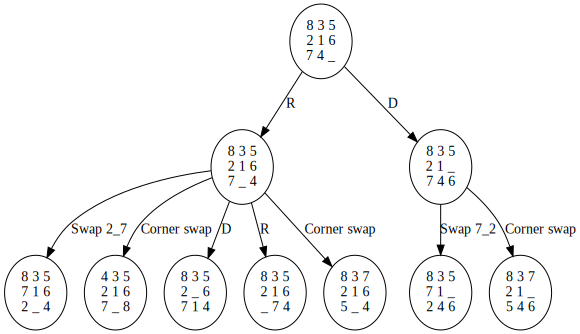

In [7]:
start_state = Node.create_random_start()

heuristic = ManhattanHeuristic()
heuristic_2 = MisplacedHeuristic()

dot = illustrate_search_tree(start_state, 10, heuristic_obj= heuristic_2)

dot


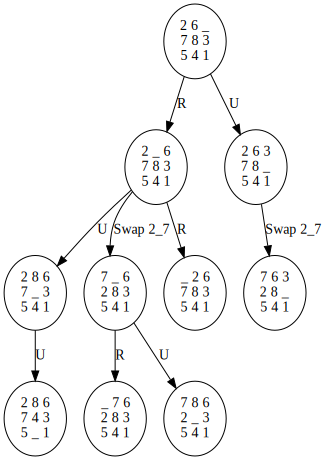

In [8]:
start_state = Node.create_random_start()
heuristic = ManhattanHeuristic()
dot = illustrate_search_tree(start_state, 10, heuristic_obj= heuristic)
dot

Cost: 7
Path length: 8
Nodes expanded: 162


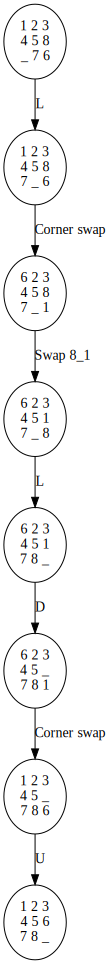

In [9]:
start_state_2 = [[1,2,3],
               [4,5,8],
               [0,7,6]]
heuristic = MisplacedHeuristic()
solver = A_star(Node(start_state_2), heuristic)
path,cost,num = solver.solve()
print("Cost:", cost)
print("Path length:", len(path))
print("Nodes expanded:", num)
dot = Digraph()
for node in path:
    node.draw(dot)
dot



Cost: 7
Path length: 8
Nodes expanded: 142


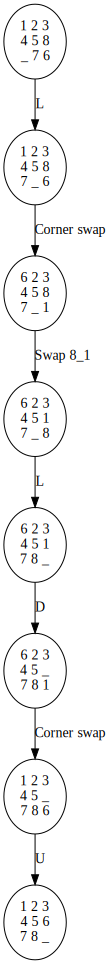

In [10]:
start_state_2 = [[1,2,3],
               [4,5,8],
               [0,7,6]]
solver = A_star(Node(start_state_2), heuristic=ManhattanHeuristic())
path,cost,num = solver.solve()
print("Cost:", cost)
print("Path length:", len(path))
print("Nodes expanded:", num)
dot = Digraph()
for node in path:
    node.draw(dot)
dot

Cost: 14
Path length: 15
Nodes expanded: 4918


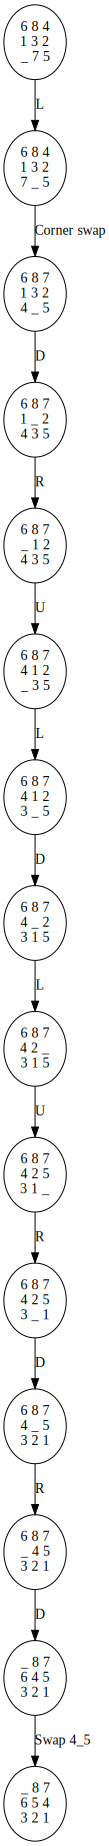

In [11]:
start_node = Node.create_random_start()
solver = A_star(start_node, heuristic=ManhattanHeuristic())
path,cost ,num= solver.solve()
print("Cost:", cost)
print("Path length:", len(path))
print("Nodes expanded:", num)
dot = Digraph()
for node in path:
    node.draw(dot)
dot

In [12]:
start_state = [[1,2,3],
               [4,5,8],
               [0,7,6]]

bfs_solver = BFS(Node(start_state), max_limit=20000)
path, cost, nodes_expanded= bfs_solver.solve()

print("Cost:", cost)
print("Length of path:", len(path) if path else None)
print("Nodes expanded:", nodes_expanded)



Cost: 7
Length of path: 8
Nodes expanded: 14464


In [13]:
def run_experiment(start_state):
    results = []

    # BFS
    bfs_solver = BFS(Node(start_state))
    t0 = time.time()
    path, cost, nodes = bfs_solver.solve()
    t1 = time.time()
    results.append(("BFS", cost, len(path) if path else None, nodes, (t1 - t0)*1000))

    # A* Manhattan
    astar_m = A_star(Node(start_state), heuristic=ManhattanHeuristic())
    t0 = time.time()
    path, cost, nodes = astar_m.solve()
    t1 = time.time()
    results.append(("A* Manhattan", cost, len(path) if path else None, nodes, (t1 - t0)*1000))

    # A* Misplaced
    astar_mp = A_star(Node(start_state), heuristic=MisplacedHeuristic())
    t0 = time.time()
    path, cost, nodes = astar_mp.solve()
    t1 = time.time()
    results.append(("A* Misplaced", cost, len(path) if path else None, nodes, (t1 - t0)*1000))

    return results


start_state = [[1,2,3],
               [4,5,8],
               [0,7,6]]

results = run_experiment(start_state)

# In bảng kết quả
print("{:<15} {:<10} {:<15} {:<15} {:<10}".format("Algorithm", "Cost", "Path length", "Nodes expanded", "Time (ms)"))
for algo, cost, path_len, nodes, time_ms in results:
    print("{:<15} {:<10} {:<15} {:<15} {:.2f}".format(algo, cost, path_len, nodes, time_ms))


Algorithm       Cost       Path length     Nodes expanded  Time (ms) 
BFS             7          8               14464           2702.36
A* Manhattan    7          8               142             46.19
A* Misplaced    7          8               162             29.22


In [14]:
def experiment(num_trials=10):
    results = {
        'manhattan': {'costs': [], 'nodes': []},
        'misplaced': {'costs': [], 'nodes': []}
    }
    for i in range(num_trials):
        start_node = Node.create_random_start()

        # Chạy A* với Manhattan
        solver_manhattan = A_star(start_node, heuristic=ManhattanHeuristic())
        path_manh, cost_manh, nodes_manh = solver_manhattan.solve()
        if path_manh is not None:
            results['manhattan']['costs'].append(cost_manh)
            results['manhattan']['nodes'].append(nodes_manh)

        # Chạy A* với Misplaced
        solver_misplaced = A_star(start_node, heuristic=MisplacedHeuristic())
        path_mis, cost_mis, nodes_mis = solver_misplaced.solve()
        if path_mis is not None:
            results['misplaced']['costs'].append(cost_mis)
            results['misplaced']['nodes'].append(nodes_mis)

        print(f"Trial {i+1}/{num_trials} completed")

    # Tính trung bình
    print("\nCOMPARED 2 HEURISTIC")
    for h in ['manhattan', 'misplaced']:
        avg_cost = statistics.mean(results[h]['costs']) if results[h]['costs'] else float('nan')
        avg_nodes = statistics.mean(results[h]['nodes']) if results[h]['nodes'] else float('nan')
        print(f"Heuristic: {h}")
        print(f"Average Path Cost   = {avg_cost:.2f}")
        print(f"Average Nodes Expanded = {avg_nodes:.2f}")
        print()

    return results


In [15]:
results = experiment(num_trials=5)


Trial 1/5 completed
Trial 2/5 completed
Trial 3/5 completed
Trial 4/5 completed
Trial 5/5 completed

COMPARED 2 HEURISTIC
Heuristic: manhattan
Average Path Cost   = 14.80
Average Nodes Expanded = 21334.00

Heuristic: misplaced
Average Path Cost   = 14.80
Average Nodes Expanded = 71454.60

